# Neural Networks for MNIST dataset

In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import numpy as np

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Loading MNIST
Here we load the dataset and create data loaders.

In [20]:
train_ds = datasets.MNIST('../data', train=True, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_ds = datasets.MNIST('../data', train=False, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

In [4]:
batch_size = 32
#batch_size = 5 # for testing
kwargs = {'num_workers': 1, 'pin_memory': True} 

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, **kwargs)

## Looking at Examples

In [5]:
train_dl = iter(train_loader)
x, y = next(train_dl)

In [6]:
print(x.shape, y.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


Helper method (from fast.ai)

In [7]:
def show(img, title=None):
    plt.imshow(img, interpolation='none', cmap="gray")
    if title is not None: plt.title(title)

In [8]:
# first from torch to numpy
X = x.numpy(); Y = y.numpy()
X.shape

(32, 1, 28, 28)

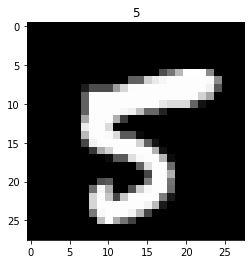

In [9]:
show(X[0][0], Y[0])

In [10]:
print(X[0][0][:4][:4])

[[-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296]
 [-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296]
 [-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421

## Feed Forward Neural Network

In [11]:
# for the number of neurons in the hidden unit
def get_model(M = 300):
    net = nn.Sequential(nn.Linear(28*28, M),
                        nn.ReLU(),
                        nn.Linear(M, 10))
    return net #.cuda()

In [12]:
def train_model(train_loader, test_loader, num_epochs, model, optimizer):
    model.train()
    sum_loss = 0.0
    total = 0
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):  
            batch = images.shape[0] # size of the batch
            # Convert torch tensor to Variable, change shape of the input
            images = images.view(-1, 28*28) #.cuda()
        
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
        
            total += batch
            sum_loss += batch * loss.item()
            if (i+1) % 100 == 0:
                print ('Epoch [%d/%d], Loss: %.4f' 
                   %(epoch+1, num_epochs, sum_loss/total))
                
        train_loss = sum_loss/total
        print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, train_loss))
        val_acc, val_loss = model_accuracy_loss(model, test_loader)
        print('Epoch [%d/%d], Valid Accuracy: %.4f, Valid Loss: %.4f' %(epoch+1, num_epochs, val_acc, val_loss))
    return val_acc, val_loss, train_loss

In [13]:
def model_accuracy_loss(model, test_loader):
    model.eval()
    correct = 0
    sum_loss = 0.0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 28*28)  #.cuda()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        loss = F.cross_entropy(outputs, labels)
        sum_loss += labels.size(0)*loss.item()
        total += labels.size(0)
        correct += pred.eq(labels.data).sum().item()
    return 100 * correct / total, sum_loss/ total

In [14]:
net = get_model()
learning_rate = 0.01
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
model_accuracy_loss(net, test_loader)

(5.81, 2.3784399974822996)

In [15]:
train_model(train_loader, test_loader, num_epochs=2, model=net, optimizer=optimizer)

Epoch [1/2], Loss: 0.7367
Epoch [1/2], Loss: 0.5800
Epoch [1/2], Loss: 0.5059
Epoch [1/2], Loss: 0.4693
Epoch [1/2], Loss: 0.4492
Epoch [1/2], Loss: 0.4312
Epoch [1/2], Loss: 0.4131
Epoch [1/2], Loss: 0.4034
Epoch [1/2], Loss: 0.3937
Epoch [1/2], Loss: 0.3851
Epoch [1/2], Loss: 0.3775
Epoch [1/2], Loss: 0.3735
Epoch [1/2], Loss: 0.3670
Epoch [1/2], Loss: 0.3632
Epoch [1/2], Loss: 0.3582
Epoch [1/2], Loss: 0.3565
Epoch [1/2], Loss: 0.3557
Epoch [1/2], Loss: 0.3512
Epoch [1/2], Loss: 0.3473
Epoch [1/2], Valid Accuracy: 92.8500, Valid Loss: 0.2543
Epoch [2/2], Loss: 0.3422
Epoch [2/2], Loss: 0.3386
Epoch [2/2], Loss: 0.3355
Epoch [2/2], Loss: 0.3329
Epoch [2/2], Loss: 0.3297
Epoch [2/2], Loss: 0.3273
Epoch [2/2], Loss: 0.3253
Epoch [2/2], Loss: 0.3229
Epoch [2/2], Loss: 0.3201
Epoch [2/2], Loss: 0.3190
Epoch [2/2], Loss: 0.3165
Epoch [2/2], Loss: 0.3156
Epoch [2/2], Loss: 0.3143
Epoch [2/2], Loss: 0.3141
Epoch [2/2], Loss: 0.3139
Epoch [2/2], Loss: 0.3131
Epoch [2/2], Loss: 0.3122
Epoch [

(92.07, 0.3064056280315854, 0.31058098874678836)

## Models with L2 regularization
To add L2 regularization use the `weight_decay` argument on the optimizer

In [16]:
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay = 0.01)

## Models with Dropout

In [17]:
def get_model_v2(M = 300, p=0):
    modules = []
    modules.append(nn.Linear(28*28, M))
    modules.append(nn.ReLU())
    if p > 0:
        modules.append(nn.Dropout(p))
    modules.append(nn.Linear(M, 10))
    return nn.Sequential(*modules) #.cuda()

In [18]:
net = get_model_v2(M = 300, p=0.1)
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [19]:
train_model(train_loader, test_loader, num_epochs=4, model=net, optimizer=optimizer)

Epoch [1/4], Loss: 0.7627
Epoch [1/4], Loss: 0.6168
Epoch [1/4], Loss: 0.5430
Epoch [1/4], Loss: 0.5011
Epoch [1/4], Loss: 0.4805
Epoch [1/4], Loss: 0.4698
Epoch [1/4], Loss: 0.4667
Epoch [1/4], Loss: 0.4585
Epoch [1/4], Loss: 0.4471
Epoch [1/4], Loss: 0.4396
Epoch [1/4], Loss: 0.4325
Epoch [1/4], Loss: 0.4326
Epoch [1/4], Loss: 0.4291
Epoch [1/4], Loss: 0.4299
Epoch [1/4], Loss: 0.4272
Epoch [1/4], Loss: 0.4255
Epoch [1/4], Loss: 0.4235
Epoch [1/4], Loss: 0.4211
Epoch [1/4], Loss: 0.4221
Epoch [1/4], Valid Accuracy: 92.2300, Valid Loss: 0.3075
Epoch [2/4], Loss: 0.4151
Epoch [2/4], Loss: 0.4074
Epoch [2/4], Loss: 0.4015
Epoch [2/4], Loss: 0.3965
Epoch [2/4], Loss: 0.3896
Epoch [2/4], Loss: 0.3862
Epoch [2/4], Loss: 0.3818
Epoch [2/4], Loss: 0.3772
Epoch [2/4], Loss: 0.3740
Epoch [2/4], Loss: 0.3702
Epoch [2/4], Loss: 0.3679
Epoch [2/4], Loss: 0.3638
Epoch [2/4], Loss: 0.3622
Epoch [2/4], Loss: 0.3597
Epoch [2/4], Loss: 0.3571
Epoch [2/4], Loss: 0.3544
Epoch [2/4], Loss: 0.3528
Epoch [

(93.92, 0.2919134729707148, 0.3045825398512709)